# Highlight->Summarize data analysis

In [1]:
import os
import tiktoken
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import NOANSWER_PRED
from run_experiments import load_all_results, PIPELINE_MAP

/home/azureuser/highlight-summarize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
RESULTS_DIR = "results/"

PRETTY_NAMES = {
    "hs": "H&S",
    "highlighter": "Highlighter",
    "neither": "Neither",
    "tie": "Tie",
    "repliqa_3": "RepliQA",
    "bioasq": "BioASQ",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini": "H&S Baseline",
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Structured Highlighter",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini": "H&S BERT Extractor (SQuAD2)",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini": "H&S BERT Extractor (RepliQA)",
}

To pandas for faster analysis.

**NOTE** if you have the `.csv`, you should jump to the cell after this one.

In [11]:
def which_pipeline(run_id):
    for pipeline in PIPELINE_MAP:
        if pipeline in run_id:
            return pipeline
    raise ValueError(f"Run ID {run_id} does not match any known pipeline.")


results_df = {}

# Try to load existing results.
for dataset_name in os.listdir(RESULTS_DIR):
    if not os.path.isdir(os.path.join(RESULTS_DIR, dataset_name)):
        continue
    # Skip small datasets.
    if "subsampled" in dataset_name:
       continue
    fname = os.path.join(RESULTS_DIR, dataset_name, "results.csv")
    if not os.path.exists(fname):
        print(f"File {fname} does not exist, skipping.")
        continue
    print(f"Loading results from {fname}")
    results_df[dataset_name] = pd.read_csv(fname)

if not results_df:
    print("No existing results found, re-generating the .csv for all datasets.")
    results = load_all_results(RESULTS_DIR)
    for dataset_name, dataset_results in results.items():
        print(f"Processing dataset: {dataset_name}")
        df_fname = os.path.join(RESULTS_DIR, dataset_name, "results.csv")

        to_cat = []

        for run_id, run_results in dataset_results.items():
            to_cat.append(pd.DataFrame(run_results))
            to_cat[-1]["pipeline"] = which_pipeline(run_id)
            to_cat[-1]["run_id"] = run_id

        df = pd.concat(to_cat, ignore_index=True)
        df.to_csv(
            os.path.join(df_fname),
            index=False,
        )
        results_df[dataset_name] = df

Loading results from results/bioasq/results.csv
Loading results from results/repliqa_3/results.csv


/tmp/ipykernel_2283736/1561184347.py:22: DtypeWarning: Columns (9,11,26,27,28,29,30,31,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  results_df[dataset_name] = pd.read_csv(fname)


# Ablation study

First, define k-precision and recall:

In [ ]:
import evaluate
bertscore = evaluate.load("bertscore")
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general hanabi"]
results = bertscore.compute(predictions=predictions, references=references, lang="en")
results

FileNotFoundError: Couldn't find a module script at /home/azureuser/highlight-summarize/microsoft/deberta-xlarge-mnli/deberta-xlarge-mnli.py. Module 'microsoft/deberta-xlarge-mnli' doesn't exist on the Hugging Face Hub either.

In [ ]:
enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def adlakha_precision_recall(gold_answers, gold_passages, answers_pred):
    """K-precision and Recall as defined in Adlakha et al. (2024).

    K-precision measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.

    Recall measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    precisions = []
    recalls = []
    for answer, passage, answer_pred in zip(gold_answers, gold_passages, answers_pred):
        if answer == NOANSWER_PRED:
            raise ValueError("Reference answer is NOANSWER_PRED.")

        if answer_pred == NOANSWER_PRED or not answer_pred or pd.isnull(answer_pred):
            return 0.0, 0.0
        
        # Precision
        passage_tokens = set(enc.encode(passage))
        answer_pred_tokens = set(enc.encode(answer_pred))
        common_tokens = passage_tokens.intersection(answer_pred_tokens)
        precision = len(common_tokens) / len(answer_pred_tokens)
        precisions.append(precision)

        # Recall
        answer_tokens = set(enc.encode(answer))
        common_tokens = answer_tokens.intersection(answer_pred_tokens)
        recall = len(common_tokens) / len(answer_tokens)
        recalls.append(recall)

    return precisions, recalls

# def ref_answer_recall(answers, answers_pred):
#     """This metric measures the proportion of tokens in the
#     reference `answer` that are present in the model response.
#     """
#     recalls = []
#     for answer, answer_pred in zip(answers, answers_pred):
#         if answer == NOANSWER_PRED:
#             raise ValueError("Reference answer is NOANSWER_PRED.")

#         if answer_pred == NOANSWER_PRED or not answer_pred or pd.isnull(answer_pred):
#             return 0.0
        
#         answer_tokens = set(enc.encode(answer))
#         answer_pred_tokens = set(enc.encode(answer_pred))
#         common_tokens = answer_tokens.intersection(answer_pred_tokens)
#         recalls.append(len(common_tokens) / len(answer_tokens))
#     return recall

# def ref_passage_precision(passage, answer_pred):
#     """This metric measures the proportion of tokens in the model
#     response `answer_pred` that are present in the "gold passage" `passage`.
#     """
#     if answer_pred == NOANSWER_PRED or not answer_pred or pd.isnull(answer_pred):
#         return 0.0
    
#     passage_tokens = set(enc.encode(passage))
#     answer_pred_tokens = set(enc.encode(answer_pred))
#     common_tokens = passage_tokens.intersection(answer_pred_tokens)
#     precision = len(common_tokens) / len(answer_pred_tokens)
#     return precision

# def bert_score(pred, ref):
#     """Compute BERTScore for the given prediction and reference."""
#     if pred == NOANSWER_PRED or not pred or pd.isnull(pred):
#         return 0.0
#     if ref == NOANSWER_PRED or not ref or pd.isnull(ref):
#         return 0.0
#     results = bertscore.compute(predictions=[pred], references=[ref], lang="en")
#     return results["f1"][0]

In [22]:
a = set([1, 2, 3])
b = set([2, 3, 4])
a.intersection(b), b.intersection(a)

({2, 3}, {2, 3})

In [21]:
ref_answer_recall("This is a test passa.", "This is a test answer."), ref_passage_precision_1("This is a test passa.", "This is a test answer.")

(0.7142857142857143, 0.8333333333333334)

## How precise are the highlighters?

We use `long_answer`, so we can only do this for the RepliQA dataset.

In [7]:
def compute_highlighter_precision(row):
    text_extracts = row["highlighter_extracted"]
    if not text_extracts or pd.isnull(text_extracts):
        return 0.0
    return ref_passage_precision(row["long_answer"], text_extracts)

def compute_highlighter_recall(row):
    text_extracts = row["highlighter_extracted"]
    if not text_extracts or pd.isnull(text_extracts):
        return 0.0
    return ref_answer_recall(row["long_answer"], text_extracts)

for dataset_name, df in results_df.items():
    if not "repliqa" in dataset_name:
        continue
    # Filter out no-answer predictions and QAEvaluator pipeline.
    df = df[df.pipeline != "QAEvaluator"]
    df = df[df.answer != NOANSWER_PRED]
    # Check that the long answer is accurate.
    df = df[df.long_answer != ""]
    df = df[df.apply(lambda x: x["long_answer"] in x["document_extracted"], axis=1)]

    df["highlighter_precision"] = df.apply(
        lambda x: compute_highlighter_precision(x),
        axis=1
    )

    df["highlighter_recall"] = df.apply(
        lambda x: compute_highlighter_recall(x),
        axis=1
    )

    print(f"Dataset: {dataset_name}")
    print(f"\\begin{{tabular}}{{lcc}}")
    print("\\toprule")
    print(f"Pipeline & Precision & Recall\\\\")
    print("\\midrule")
    for run_id in df.run_id.unique():
        run_id_df = df[df.run_id == run_id]
        if len(run_id_df) == 0:
            continue
        print((
            # f"{run_id} & {run_id_df['highlighter_precision'].mean():.4f} (std: {run_id_df['highlighter_precision'].std():.4f})"
            # f" & {run_id_df['highlighter_recall'].mean():.4f} (std: {run_id_df['highlighter_recall'].std():.4f})\\\\"))
            f"{PRETTY_NAMES[run_id]} & {run_id_df['highlighter_precision'].mean():.2}"
            f" & {run_id_df['highlighter_recall'].mean():.2}\\\\"))
    print("\\bottomrule")
    print(f"\\end{{tabular}}")

    # Worst examples (that aren't NaN).
    for run_id in df.run_id.unique():
        run_id_df = df[df.run_id == run_id]
        run_id_df = run_id_df[~pd.isnull(run_id_df.highlighter_extracted)]
        if len(run_id_df) == 0:
            continue
        worst_examples = run_id_df.sort_values("highlighter_precision").head(1)
        print(f"Worst examples for {run_id}:")
        for _, row in worst_examples.iterrows():
            print(f"  - {row['highlighter_precision']:.4f}")
            print(f"    Long answer: {row['long_answer']}")
            print(f"    Extracted: {row['highlighter_extracted']}")
        print("=" * 80)

Dataset: repliqa_3
\begin{tabular}{lcc}
\toprule
Pipeline & Precision & Recall\\
\midrule
H\&S Baseline & 0.84 & 0.65\\
H&S Structured Highlighter & 0.84 & 0.76\\
H&S BERT Extractor (SQuAD2) & 0.55 & 0.22\\
H&S BERT Extractor (RepliQA) & 0.8 & 0.36\\
\bottomrule
\end{tabular}
Worst examples for HSBaseline-gpt-4.1-mini-gpt-4.1-mini:
  - 0.0000
    Long answer: To understand the efficiency of such integration, we turn to cities like Copenhagen and Amsterdam, where seamless transitions between cycling and public transportation have been the norm. Post-2023, these cities reported a significant uptick in public transit usage while also experiencing a decline in traffic congestion. According to a study published by the University of Copenhagen on November 15, 2023, the average commute time dropped by 12 percent after integrating bike-sharing with public transport.
    Extracted: Copenhagen
Amsterdam
Worst examples for HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini:
  - 0.0553
    Long ans

## Can the summarizer guess what was the question?

In [ ]:
def compute_question_precision(row):
    guessed_question = row["summarizer_llm_guessed_question"]
    if not guessed_question or pd.isnull(guessed_question):
        return 0.0
    return ref_passage_precision(row["question"], guessed_question)

def compute_question_recall(row):
    guessed_question = row["summarizer_llm_guessed_question"]
    if not guessed_question or pd.isnull(guessed_question):
        return 0.0
    return ref_answer_recall(row["question"], guessed_question)

for dataset_name, df in results_df.items():
    if not "repliqa" in dataset_name:
        continue
    # Filter out no-answer predictions and QAEvaluator pipeline.
    df = df[df.pipeline != "QAEvaluator"]
    df = df[df.answer != NOANSWER_PRED]
    df = df[df.highlighter_extracted != ""]
    df = df[~pd.isnull(df.highlighter_extracted)]
    df = df[df.summarizer_llm_guessed_question != ""]
    df = df[~pd.isnull(df.summarizer_llm_guessed_question)]


    df["guessed_question_precision"] = df.apply(
        lambda x: compute_question_precision(x),
        axis=1
    )

    df["guessed_question_recall"] = df.apply(
        lambda x: compute_question_recall(x),
        axis=1
    )

    print(f"Dataset: {dataset_name}")
    print(f"\\begin{{tabular}}{{lcc}}")
    print("\\toprule")
    print(f"Pipeline & Precision & Recall\\\\")
    print("\\midrule")
    for run_id in df.run_id.unique():
        run_id_df = df[df.run_id == run_id]
        if len(run_id_df) == 0:
            continue
        print((
            f"{PRETTY_NAMES[run_id]} & {run_id_df['guessed_question_precision'].mean():.2}"
            f" & {run_id_df['guessed_question_recall'].mean():.2}\\\\"))
    print("\\bottomrule")
    print(f"\\end{{tabular}}")

    # Worst examples (that aren't NaN).
    for run_id in df.run_id.unique():
        run_id_df = df[df.run_id == run_id]
        run_id_df = run_id_df[~pd.isnull(run_id_df.summarizer_llm_guessed_question)]
        if len(run_id_df) == 0:
            continue
        worst_examples = run_id_df.sort_values("guessed_question_precision").head(2)
        print(f"Worst examples for {run_id}:")
        for _, row in worst_examples.iterrows():
            print(f"  - {row['guessed_question_precision']:.4f}")
            print(f"    Question: {row['question']}")
            print(f"    Guessed: {row['summarizer_llm_guessed_question']}")
            print(f"    Context: {row['highlighter_extracted'][:20]}...")
        print("=" * 80)

Dataset: repliqa_3
\begin{tabular}{lcc}
\toprule
Pipeline & Precision & Recall\\
\midrule
H\&S Baseline & 0.46 & 0.39\\
H\&S Structured Highlighter & 0.55 & 0.49\\
H\&S BERT Extractor (SQuAD2) & 0.29 & 0.21\\
H\&S BERT Extractor (RepliQA) & 0.41 & 0.34\\
\bottomrule
\end{tabular}
Worst examples for HSBaseline-gpt-4.1-mini-gpt-4.1-mini:
  - 0.0000
    Question: How do Community Learning Centers adapt to remain relevant according to Dr. Elena Rodriguez's insights at the Global Education Symposium?
    Guessed: What is a key characteristic of successful community learning centers (CLCs)?
    Context: On October 15, 2023,...
  - 0.0000
    Question: Which key demographic showed an increasing preference for eco-responsible products at NimbleFootwear Inc.?
    Guessed: What are the preferences of Millennials and Generation Z regarding product choices?
    Context: "Millennials and Gen...
Worst examples for HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini:
  - 0.0000
    Question: What is th

Correlation between guessed question F1 and `PollMultihopCorrectness-gpt-4.1-mini_correctness_rating`.

In [39]:
dfhss = df[df.pipeline == "HSBaseline"]
dfhss[dfhss["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"] == True].guessed_question_f1.mean()

np.float64(0.4121150166158082)

In [41]:
df[df.pipeline == "HSBaseline"].run_id.unique()

array(['HSBaseline-gpt-4.1-mini-gpt-4.1-mini'], dtype=object)

In [40]:
dfhss = df[df.pipeline == "HSBaseline"]
dfhss[dfhss["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"] == False].guessed_question_f1.mean()

np.float64(0.3984216974113943)

In [28]:
df[df["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"] == False].guessed_question_precision.mean()

np.float64(0.30692292663154)

<Axes: xlabel='guessed_question_precision', ylabel='answer_precision'>

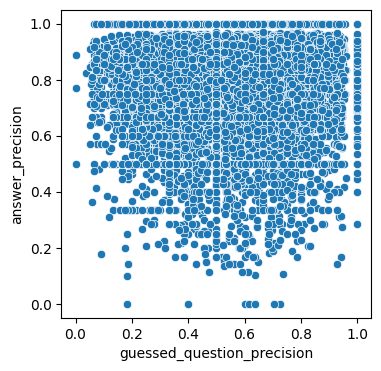

In [47]:
df["guessed_question_f1"] = 2 * (df["guessed_question_precision"] * df["guessed_question_recall"]) / (df["guessed_question_precision"] + df["guessed_question_recall"])
df["answer_precision"] = df.apply(
    lambda x: ref_passage_precision(x["long_answer"], x["answer"]),
    axis=1
)
df["answer_recall"] = df.apply(
    lambda x: ref_answer_recall(x["long_answer"], x["answer"]),
    axis=1
)
df["answer_f1"] = 2 * (df["answer_precision"] * df["answer_recall"]) / (df["answer_precision"] + df["answer_recall"])


dfhss = df[df.pipeline == "HSStructuredHighlighter"]
plt.figure(figsize=(4, 4))
# sns.histplot(
#     dfhss,
#     x="guessed_question_precision",
#     hue="PollMultihopCorrectness-gpt-4.1-mini_correctness_rating",
#     stat="probability",
#     common_norm=False,
# )
sns.scatterplot(
    data=dfhss,
    x="guessed_question_precision",
    y="answer_precision",
)

In [123]:
df[["question", "summarizer_llm_guessed_question", "guessed_question_precision", "guessed_question_recall"]].head(10)

,question,summarizer_llm_guessed_question,guessed_question_precision,guessed_question_recall
17955,Who is the upstart candidate in Jakarta's elec...,Who is Amira Bintang and what are the main foc...,0.315789,0.400000
17956,What innovative form of civic engagement did B...,What is an example of an innovative civic enga...,0.466667,0.333333
17957,When did the impassioned campaign rally by Bin...,What did Bintang discuss at the rally on Octob...,0.500000,0.500000
17958,When did the debate happen about Jakarta's rea...,What was the main topic of the debate between ...,0.136364,0.187500
17959,Which candidate's campaign is funded largely t...,How do Bintang's and Harahap's campaign fundin...,0.266667,0.266667
17960,What are the age groups targeted by the NutriE...,"What is the ""NutriEd"" program and how is it im...",0.352941,0.400000
17961,What has been the observed effect of the Nutri...,How has the implementation of 'NutriEd' teachi...,0.444444,0.444444
17962,What evidence suggests that the NutriEd digita...,How successful and useful have the 'NutriEd' a...,0.300000,0.375000
17963,How has the NutriEd program in Baltimore addre...,How did NutriEd address the challenge of digit...,0.812500,0.722222
17964,What long-term potential does the NutriEd prog...,What are the future plans of the Baltimore Com...,0.750000,0.521739


In [ ]:
worst = run_id_df.iloc[np.where(~pd.isnull(run_id_df.summarizer_llm_guessed_question))]
# Sort and keep the worst 5.
worst = worst.sort_values(by="guess_prediction_accuracy", ascending=True).head(5)
#worst = worst.iloc[np.where(worst.guess_prediction_accuracy < 0.88)]
print("\\begin{tabularx}{\\textwidth}{cXX}")
print("\\toprule")
print("Score & Real question & Guessed question \\\\")
print("\\midrule")
for _, w in worst.iterrows():
    # print("-"*20)
    # print(f"Score: {w.guess_prediction_accuracy:.4f}")
    # print(f"Real question:    {w.question}")
    # print(f"Guessed question: {w.summarizer_llm_guessed_question}")
    # print(f"Document: {w.long_answer}")
    # print()
    # Into a latex table.
    print(f"{w.guess_prediction_accuracy:.4f} & {w.question} & {w.summarizer_llm_guessed_question} \\\\")

print("\\bottomrule")
print("\\end{tabularx}")

\begin{tabularx{\textwidth}{cXX}
\toprule
Score & Real question & Guessed question \
\midrule
0.8421 & How often does Apex Innovations review expense submissions for reimbursement? & How often does Apex Innovations review employee submissions for reimbursement? \\
0.8529 & What event at Crystal River is scheduled for October 5, 2023, for anglers? & When and where is the "Silver Strike" competition taking place, and what is its objective? \\
0.8571 & How do MarketLeader Inc. suggest SMEs stay current with competitors' strategic moves? & How do innovative companies like MarketLeader Inc. suggest SMEs keep up with competitors' strategies? \\
0.8571 & What example was reported by the 'Journal of Healthcare Law' illustrating a gap in the respect for advanced directives? & What is an example illustrating the inconsistent respect for advanced directives across jurisdictions as reported by the Journal of Healthcare Law? \\
0.8571 & What is the staggering percentage of freshwater resources cons

## The importance of a generative summarizer

Here we evaluate the extractive pipeline (without generation).

In [58]:
for dataset_name, dataset_results in results_df.items():
    # Remove unanswerable.
    dataset_results = dataset_results[dataset_results.answer != NOANSWER_PRED]
    print(f"Dataset: {dataset_name}")
    print("\\begin{{tabular}}{{lcc}}")
    print("\\toprule")
    print("Pipeline (run_id) & Average Recall & Average Precision \\\\")
    for run_id in dataset_results.run_id.unique():
        if "QAExtractor" in run_id:
            continue
        df = dataset_results[dataset_results.run_id == run_id]
        df = df[df.highlighter_extracted != ""]
        df = df[df.highlighter_extracted.notnull()]
        if len(df) == 0:
            continue
        df["ref_answer_recall"] = df.apply(
            lambda row: ref_answer_recall(row["answer"], row["highlighter_extracted"]), axis=1
        )
        if "long_answer" in df.columns:
            df["ref_passage_precision"] = df.apply(
                lambda row: ref_passage_precision(row["long_answer"], row["highlighter_extracted"]), axis=1
            )
        else:
            # NOTE: must add caveat here.
            df["ref_passage_precision"] = df.apply(
                lambda row: ref_passage_precision(row["answer"], row["highlighter_extracted"]), axis=1
            )
        avg_precision = df["ref_passage_precision"].mean()
        
        avg_recall = df["ref_answer_recall"].mean()
        print(f"{run_id} & {avg_recall:.4f} & {avg_precision:.4f} \\\\")
    print("\\bottomrule")
    print("\\end{{tabular}}")

Dataset: repliqa_3-subsampled
\begin{{tabular}}{{lcc}}
\toprule
Pipeline (run_id) & Average Recall & Average Precision \\
HSBaseline-gpt-4.1-mini-gpt-4.1-mini & 0.7353 & 0.9027 \\
HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini & 0.7834 & 0.9062 \\
HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini & 0.4530 & 0.7829 \\
HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini & 0.2932 & 0.4689 \\
\bottomrule
\end{{tabular}}
Dataset: bioasq-subsampled
\begin{{tabular}}{{lcc}}
\toprule
Pipeline (run_id) & Average Recall & Average Precision \\
HSBaseline-gpt-4.1-mini-gpt-4.1-mini & 0.6271 & 0.3290 \\
HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini & 0.7384 & 0.2859 \\
HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini & 0.3189 & 0.4208 \\
HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini & 0.2182 & 0.2868 \\
\bottomrule
\end{{tabular}}


Dataset: comparison-HSBaseline-gpt-4.1-mini-gpt-4.1-mini-highlighter_vs_hs.jsonl
\begin{tabular}{l|c}
\toprule
Preference & Count \\
\midrule
H&S & 0.5433 \\
Tie & 0.2914 \\
Neither & 0.1072 \\
Highlighter & 0.0581 \\
\bottomrule
\end{tabular}


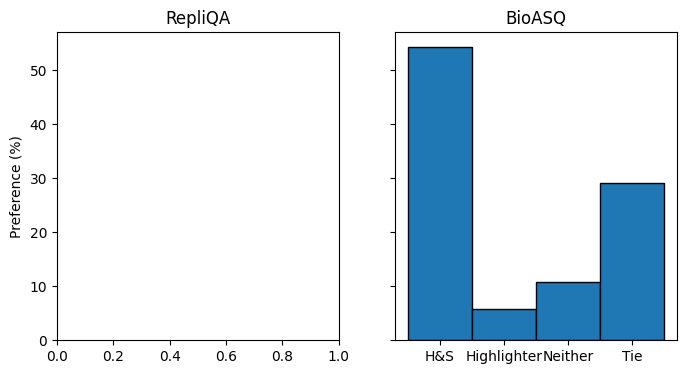

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for ax, dataset_name in zip(axes, ["repliqa_3", "bioasq"]):
    ax.set_title(PRETTY_NAMES[dataset_name])
    dataset_folder = f"{RESULTS_DIR}/{dataset_name}/"
    for fname in os.listdir(dataset_folder):
        if not fname.endswith("highlighter_vs_hs.jsonl"):
            continue
        df = pd.read_json(os.path.join(dataset_folder, fname), lines=True)
        df.preference = df.preference.map(lambda x: PRETTY_NAMES.get(x, x))
        
        sns.histplot(
            data=df,
            x="preference",
            # hue="pipeline",
            stat="percent",
            bins=30,
            alpha=1,
            legend=False,
        )
        # As a latex table.
        print(f"Dataset: {fname}")
        print("\\begin{tabular}{l|c}")
        print("\\toprule")
        print("Preference & Count \\\\")
        print("\\midrule")
        for pref, count in df.value_counts("preference").items():
            # Normalize by the total number of samples.
            print(f"{pref} & {count / len(df):.4f} \\\\")
        print("\\bottomrule")
        print("\\end{tabular}")
    
    if ax == axes[0]:
        ax.set_ylabel("Preference (%)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

# Full pipelines comparison: vanilla vs HS RAG

## Answerable questions

### K-precision and recall

In [48]:
for dataset_name, dataset_results in results_df.items():
    # Remove unanswerable.
    dataset_results = dataset_results[dataset_results.answer != NOANSWER_PRED]
    print(f"Dataset: {dataset_name}")
    print("\\begin{{tabular}}{{lcc}}")
    print("\\toprule")
    print("Pipeline (run_id) & Average Recall & Average Precision \\\\")
    for run_id in dataset_results.run_id.unique():
        df = dataset_results[dataset_results.run_id == run_id]
        if len(df) == 0:
            continue
        df["ref_answer_recall"] = df.apply(
            lambda row: ref_answer_recall(row["answer"], row["answer_pred"]), axis=1
        )
        if "long_answer" in df.columns:
            df["ref_passage_precision"] = df.apply(
                lambda row: ref_passage_precision(row["long_answer"], row["answer_pred"]), axis=1
            )
        else:
            # NOTE: must add caveat here.
            df["ref_passage_precision"] = df.apply(
                lambda row: ref_passage_precision(row["answer"], row["answer_pred"]), axis=1
            )
        avg_precision = df["ref_passage_precision"].mean()
        
        avg_recall = df["ref_answer_recall"].mean()
        print(f"{run_id} & {avg_recall:.4f} & {avg_precision:.4f} \\\\")
    print("\\bottomrule")
    print("\\end{{tabular}}")

Dataset: bioasq
\begin{{tabular}}{{lcc}}
\toprule
Pipeline (run_id) & Average Recall & Average Precision \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini & 0.5543 & 0.3067 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


QAEvaluator-gpt-4.1-mini & 0.3695 & 0.5552 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSBaseline-gpt-4.1-mini-gpt-4.1-mini & 0.5229 & 0.2999 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini & 0.2191 & 0.2414 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini & 0.3031 & 0.2411 \\
\bottomrule
\end{{tabular}}
Dataset: repliqa_3
\begin{{tabular}}{{lcc}}
\toprule
Pipeline (run_id) & Average Recall & Average Precision \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


QAEvaluator-gpt-4.1-mini & 0.7137 & 0.7614 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSBaseline-gpt-4.1-mini-gpt-4.1-mini & 0.6863 & 0.6721 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini & 0.7325 & 0.6807 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(
/tmp/ipykernel_2117820/2130676698.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini & 0.3431 & 0.4820 \\


/tmp/ipykernel_2117820/2130676698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_answer_recall"] = df.apply(


HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini & 0.5854 & 0.6187 \\
\bottomrule
\end{{tabular}}


/tmp/ipykernel_2117820/2130676698.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ref_passage_precision"] = df.apply(


In [49]:
DATASET = "repliqa_3-subsampled"
for run_id in results_df[DATASET].run_id.unique():
    df = results_df[DATASET][results_df[DATASET].run_id == run_id]
    df = df[df.answer != NOANSWER_PRED]
    print(f"Run ID: {run_id}")
    
    # Calculate recall and precision
    df["ref_answer_recall"] = df.apply(
        lambda row: ref_answer_recall(row["answer"], row["answer_pred"]), axis=1
    )
    df["ref_passage_precision"] = df.apply(
        lambda row: ref_passage_precision(row["long_answer"], row["answer_pred"]), axis=1
    )
    
    # Print statistics
    print(f"Average Recall: {df['ref_answer_recall'].mean():.4f}")
    print(f"Average Precision: {df['ref_passage_precision'].mean():.4f}")

KeyError: 'repliqa_3-subsampled'

### LLM as a judge

#### PollMultihopCorrectness

Provides yes/no ratings.

/tmp/ipykernel_2117820/1709757925.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2117820/1709757925.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


{'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini': np.float64(0.8690400508582327), 'QAEvaluator-gpt-4.1-mini': np.float64(0.8512396694214877), 'HSBaseline-gpt-4.1-mini-gpt-4.1-mini': np.float64(0.863318499682136), 'HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini': np.float64(0.7446492901038355), 'HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini': np.float64(0.7202797202797203)}
{'QAEvaluator-gpt-4.1-mini': np.float64(0.9292532285233015), 'HSBaseline-gpt-4.1-mini-gpt-4.1-mini': np.float64(0.9342363840539023), 'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini': np.float64(0.9550814149354295), 'HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini': np.float64(0.5694834362717575), 'HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini': np.float64(0.8076923076923077)}


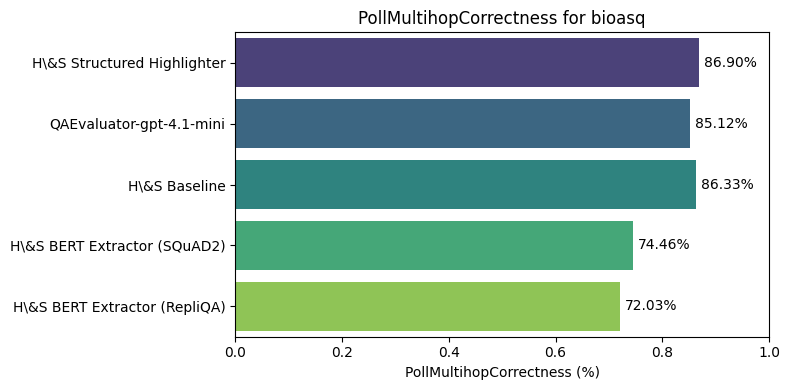

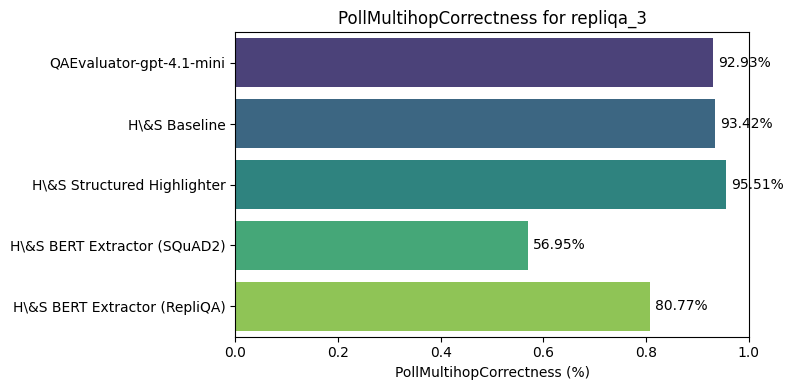

In [68]:
for dataset_name, df in results_df.items():
    # Filter out no-answer predictions.
    df = df[df.answer != NOANSWER_PRED]
    correct = {}
    for run_id in df.run_id.unique():
        correct[run_id] = np.mean(
            df[df.run_id == run_id]["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"] == True
        )
    
    # Barplot where the x-axis is the correctness percentage and the y-axis is the pipeline name.
    # Includes % numbers on the bars (to their right).
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=list(correct.values()),
        y=list(correct.keys()),
        palette="viridis",
        formatter=lambda x: PRETTY_NAMES.get(x, x),
    )
    # Show the % correct on the bars.
    for i, v in enumerate(correct.values()):
        plt.text(v + 0.01, i, f"{v:.2%}", ha='left', va='center')
    plt.xlim(0, 1)
    plt.title(f"PollMultihopCorrectness for {dataset_name}")
    plt.xlabel("PollMultihopCorrectness (%)")
    plt.ylabel("")
    # plt.xticks(rotation=90)
    plt.tight_layout()

    print(correct)

#### ReliableCIRelevance

Provides a relevance score from 0 to 3.

In [47]:
df["ReliableCIRelevance-gpt-4.1-mini_quality_rating"].unique()

array([2, 3, 1])

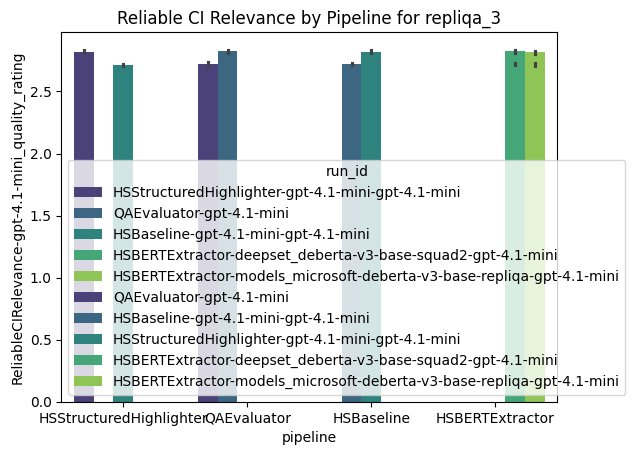

In [62]:
for dataset_name, df in results_df.items():
    # Filter out no-answer predictions.
    df = df[df.answer != NOANSWER_PRED]
    sns.barplot(
        x="pipeline",
        y="ReliableCIRelevance-gpt-4.1-mini_quality_rating",
        palette="viridis",
        data=df,
        hue="run_id",
    )
    plt.title(f"Reliable CI Relevance by Pipeline for {dataset_name}")

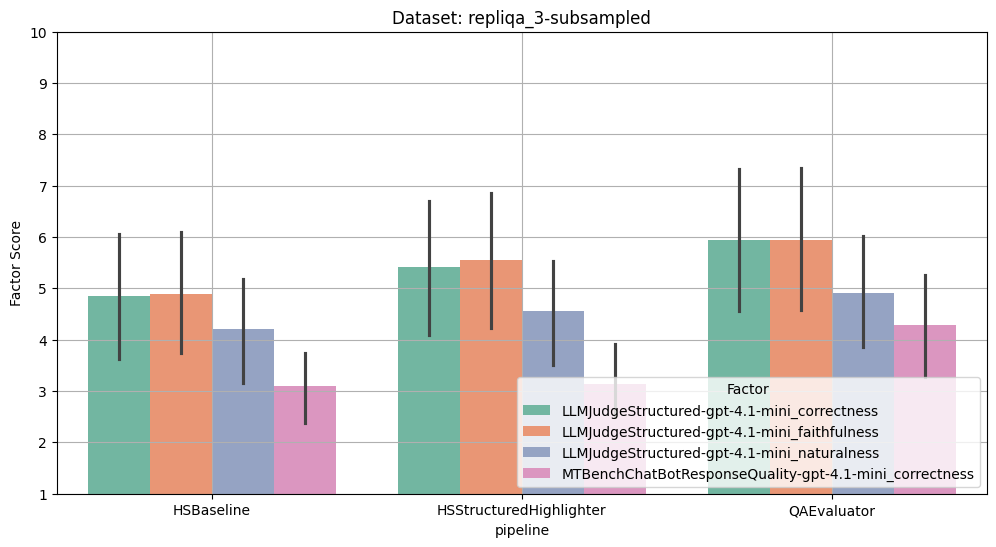

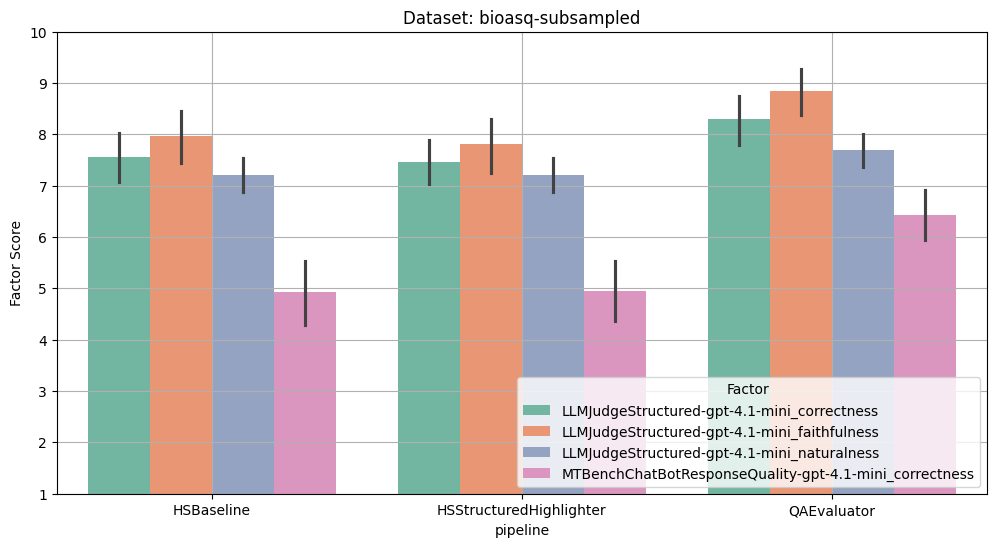

In [28]:
factors = ["_".join(col.split("_")[:2]) for col in judges_columns if col.endswith("_rating")]
factors = [f for f in factors if "PollMultihopCorrectness" not in f]
factors = [f for f in factors if "ReliableCIRelevance" not in f]

for dataset_name, df in results_df.items():
    # Filter out no-answer predictions.
    df = df[df.answer_pred != NOANSWER_PRED]
    # Each factor gets a replica of the data, and we then concatenate.
    to_cat = []
    for factor in factors:
        df_factor = df.copy()
        df_factor["factor"] = factor
        df_factor["factor_rating"] = df_factor[f"{factor}_rating"]
        to_cat.append(df_factor)
    df = pd.concat(to_cat, ignore_index=True)

    # Violin plot for each run_id (i.e., config). Hue is the factor.
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="pipeline",
        y="factor_rating",
        hue="factor",
        data=df,
        palette="Set2",
    )
    plt.ylabel("Factor Score")
    plt.ylim(1, 10)
    plt.grid()
    plt.legend(loc="lower right", title="Factor")
    plt.title(f"Dataset: {dataset_name}")

## Unanswerable questions

In [49]:
# Confusion matrix for (answer is answerable/unanswerable, answer_pred is answerable/unanswerable)
judged_dataset = results_df["repliqa_3"]
for model_name in judged_dataset:
    answerable = judged_dataset[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    unanswerable = judged_dataset[model_name].filter(
        lambda example: example["answer"] == NOANSWER_PRED
    )
    answerable_correct = len(answerable.filter(lambda example: example["answer_pred"] != NOANSWER_PRED))
    unanswerable_correct = len(unanswerable.filter(lambda example: example["answer_pred"] == NOANSWER_PRED))

    # Plot as confusion matrix.
    confusion_matrix = np.array([[answerable_correct, len(answerable) - answerable_correct],
                                  [len(unanswerable) - unanswerable_correct, unanswerable_correct]])
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted") 

KeyError: 'repliqa_3'

# Pairwise comparisons

Load and convert to "battles" format for easier parsing.

In [47]:
dataset_results = f"{RESULTS_DIR}/bioasq"
battles = []
for comparison in os.listdir(dataset_results):
    if not comparison.startswith("comparison-") or comparison.endswith("highlighter_vs_hs.jsonl"):
        continue
    model_a, model_b = comparison[len("comparison-"):-len(".jsonl")].split("_vs_")
    print(f"Processing comparison: {model_a} vs {model_b}")
    df = pd.read_json(os.path.join(dataset_results, comparison), lines=True)
    for _, row in df.iterrows():
        if row["preference"] == "neither":
            winner = "tie (bothbad)"
        elif row["preference"] in [model_a, model_b]:
            winner = "model_a" if row["preference"] == model_a else "model_b"
        elif row["preference"] == "tie":
            winner = "tie"
        else:
            raise ValueError(f"Unexpected preference value: {row['preference']}")

        battles.append({
            "model_a": model_a,
            "model_b": model_b,
            "winner": winner,
        })
battles = pd.DataFrame(battles)

Processing comparison: QAEvaluator-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: QAEvaluator-gpt-4.1-mini vs HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini
Processing comparison: HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: QAEvaluator-gpt-4.1-mini vs HSBaseline-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: HSBaseline-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini
Processing comparison: HSBaseline-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini vs HSBaseline-gpt-4.1-mini-gpt-4.1-mini


<Axes: xlabel='model_b', ylabel='model_a'>

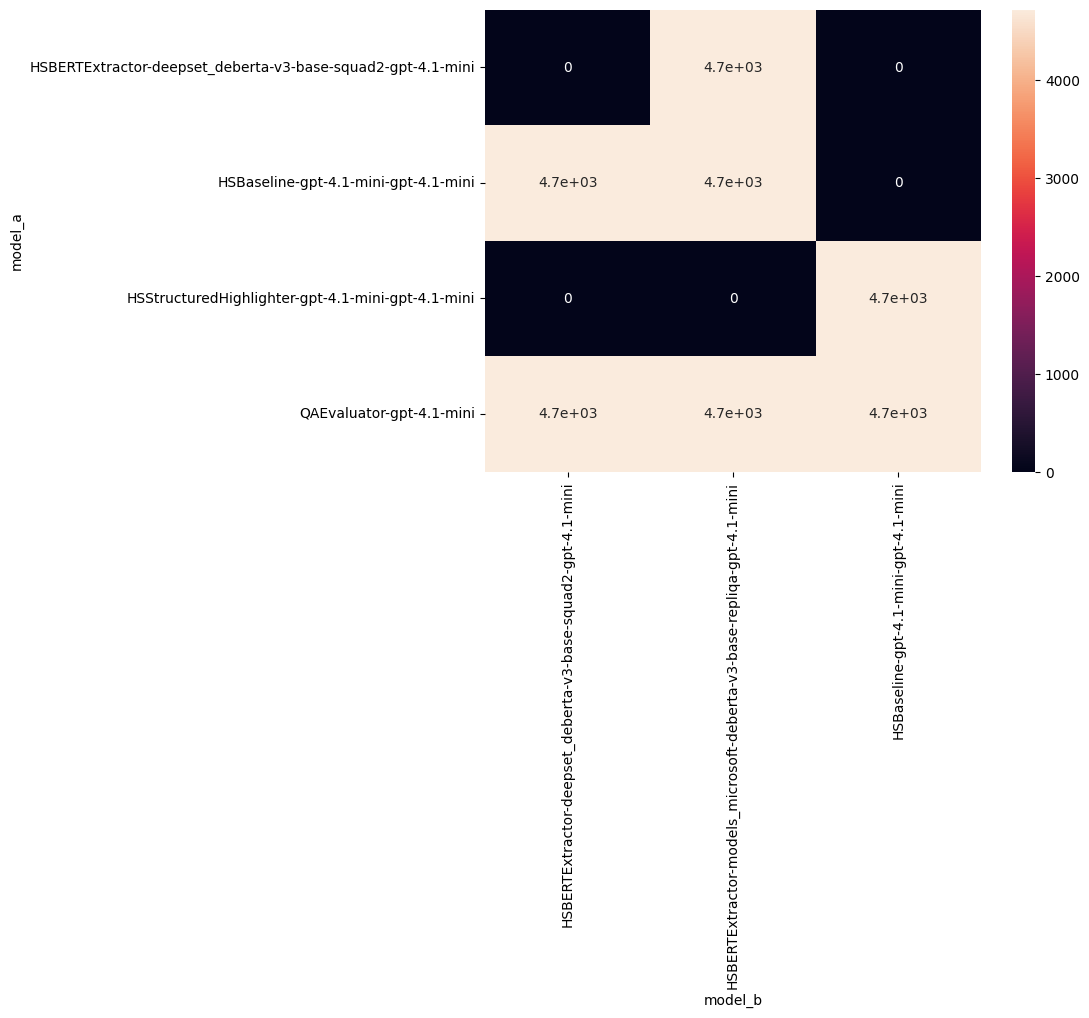

In [57]:
plt.figure(figsize=(8, 6))

sns.heatmap(
    data=pd.pivot_table(battles, index="model_a", columns="model_b", aggfunc="size", fill_value=0),
    annot=True,
)

In [34]:
from collections import defaultdict

def compute_online_elo(battles, K=4, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, winner in battles[['model_a', 'model_b', 'winner']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if winner == "model_a":
            sa = 1
        elif winner == "model_b":
            sa = 0
        elif winner == "tie" or winner == "tie (bothbad)":
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {winner}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    # calibrate llama-13b to 800
    # delta = (800-rating["llama-13b"])
    # for model in battles["model_a"].unique():
    #     rating[model] += delta

    return rating

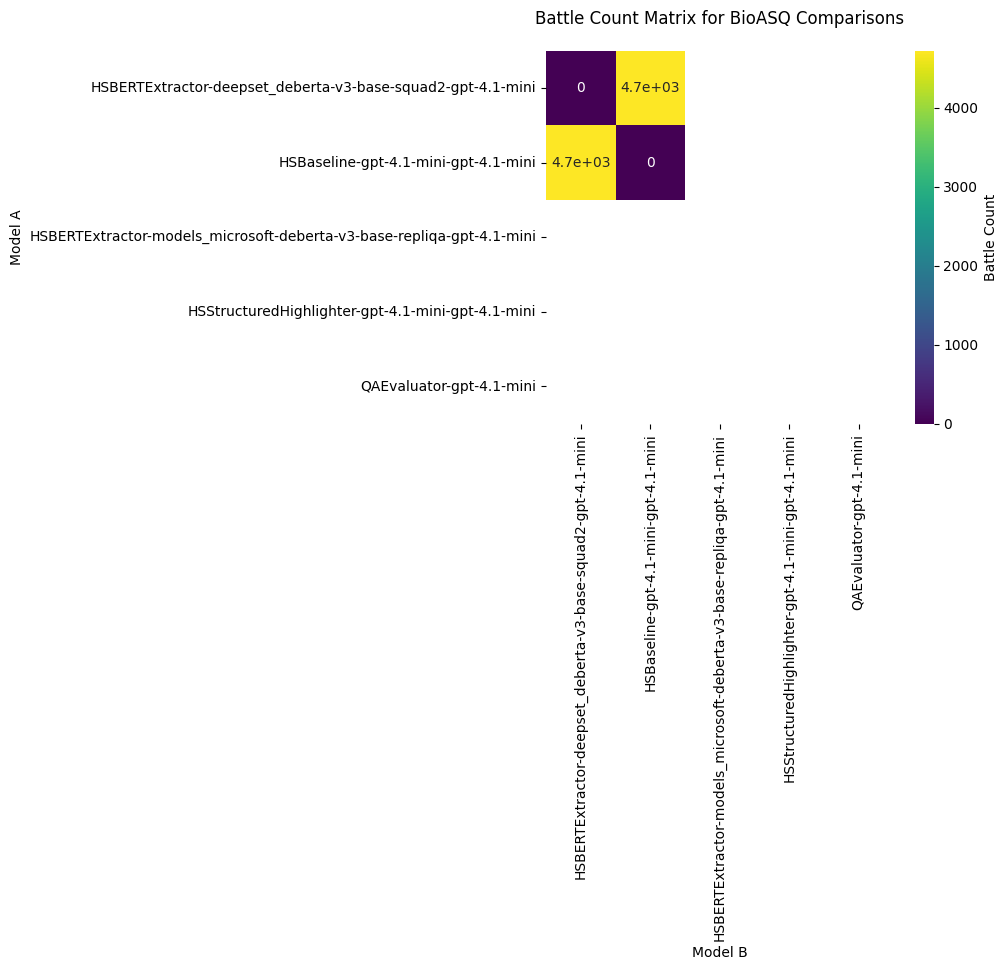

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

def visualize_battle_count(battles, title):
    # Create pivot table
    ptbl = pd.pivot_table(battles, index="model_a", columns="model_b", aggfunc="size", fill_value=0)
    
    # Make the matrix symmetric
    battle_counts = ptbl + ptbl.T
    
    # Determine ordering of models by total battles
    ordering = battle_counts.sum().sort_values(ascending=False).index
    
    # Subset the matrix to top models
    battle_counts_subset = battle_counts.loc[ordering, ordering]
    
    # Set figure size
    rcParams['figure.figsize'] = 10, 10
    
    # Create heatmap using seaborn
    plt.figure()
    ax = sns.heatmap(battle_counts_subset, annot=True, cmap="viridis", cbar_kws={'label': 'Battle Count'})
    
    # Set titles and labels
    plt.title(title, y=1.05)
    ax.set_xlabel("Model B")
    ax.set_ylabel("Model A")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

visualize_battle_count(battles, "Battle Count Matrix for BioASQ Comparisons")

In [38]:
import math

def compute_mle_elo(
    df, SCALE=400, BASE=10, INIT_RATING=1000,
):
    from sklearn.linear_model import LogisticRegression
    ptbl_a_win = pd.pivot_table(
        df[df["winner"] == "model_a"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    # if no tie, create a zero matrix
    if sum(df["winner"].isin(["tie", "tie (bothbad)"])) == 0:
        ptbl_tie = pd.DataFrame(0, index=ptbl_a_win.index, columns=ptbl_a_win.columns)
    else:
        ptbl_tie = pd.pivot_table(
            df[df["winner"].isin(["tie", "tie (bothbad)"])],
            index="model_a",
            columns="model_b",
            aggfunc="size",
            fill_value=0,
        )
        ptbl_tie = ptbl_tie + ptbl_tie.T

    ptbl_b_win = pd.pivot_table(
        df[df["winner"] == "model_b"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    ptbl_win = ptbl_a_win * 2 + ptbl_b_win.T * 2 + ptbl_tie

    models = pd.Series(np.arange(len(ptbl_win.index)), index=ptbl_win.index)

    p = len(models)
    X = np.zeros([p * (p - 1) * 2, p])
    Y = np.zeros(p * (p - 1) * 2)

    cur_row = 0
    sample_weights = []
    for m_a in ptbl_win.index:
        for m_b in ptbl_win.columns:
            if m_a == m_b:
                continue
            # if nan skip
            if math.isnan(ptbl_win.loc[m_a, m_b]) or math.isnan(ptbl_win.loc[m_b, m_a]):
                continue
            X[cur_row, models[m_a]] = +math.log(BASE)
            X[cur_row, models[m_b]] = -math.log(BASE)
            Y[cur_row] = 1.0
            sample_weights.append(ptbl_win.loc[m_a, m_b])

            X[cur_row + 1, models[m_a]] = math.log(BASE)
            X[cur_row + 1, models[m_b]] = -math.log(BASE)
            Y[cur_row + 1] = 0.0
            sample_weights.append(ptbl_win.loc[m_b, m_a])
            cur_row += 2
    X = X[:cur_row]
    Y = Y[:cur_row]

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-6)
    lr.fit(X, Y, sample_weight=sample_weights)
    elo_scores = SCALE * lr.coef_[0] + INIT_RATING
    if "mixtral-8x7b-instruct-v0.1" in models.index:
        elo_scores += 1114 - elo_scores[models["mixtral-8x7b-instruct-v0.1"]]
    return pd.Series(elo_scores, index=models.index).sort_values(ascending=False)

In [39]:
compute_mle_elo(pd.DataFrame(battles))

HSBaseline-gpt-4.1-mini-gpt-4.1-mini                                     1176.831187
HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini                        1000.000000
HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini    1000.000000
QAEvaluator-gpt-4.1-mini                                                 1000.000000
HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini               823.168813
dtype: float64

##### Correct questions (among those that can be answered)

In [ ]:
MIN_RATING = 1
MAX_RATING = 5
judge_name = "MT-bench-QA"

ratings = {}

for experiment_name, res in results.items():
    dataset_name = res["config"]["dataset"]
    judged_predictions = res["judged_dataset"]
    
    if dataset_name not in ratings:
        ratings[dataset_name] = {}
    
    for model_name, judged_preds in judged_predictions.items():
        dataset = judged_preds.filter(
            lambda example: example["answer"] != NOANSWER_PRED,
            load_from_cache_file=False
        )
        
        for factor in ["correctness", "faithfulness", "naturalness"]:
            col = f"{judge_name}_{factor}"
            ratings[dataset_name].setdefault(model_name, {})[col] = dataset[col]
    
    
for dataset_name, judged_predictions in results.items():
    ratings[dataset_name] = {}
    for model_name in judged_predictions:
        dataset = judged_predictions[model_name].filter(
            lambda example: example["answer"] != NOANSWER_PRED,
            load_from_cache_file=False
        )
        for factor in ["correctness", "faithfulness", "naturalness"]:
            col = f"{judge_name}_{factor}"
            ratings[dataset_name].setdefault(model_name, {})[col] = dataset[col]

Filter: 100%|██████████| 40/40 [00:00<00:00, 9228.39 examples/s]


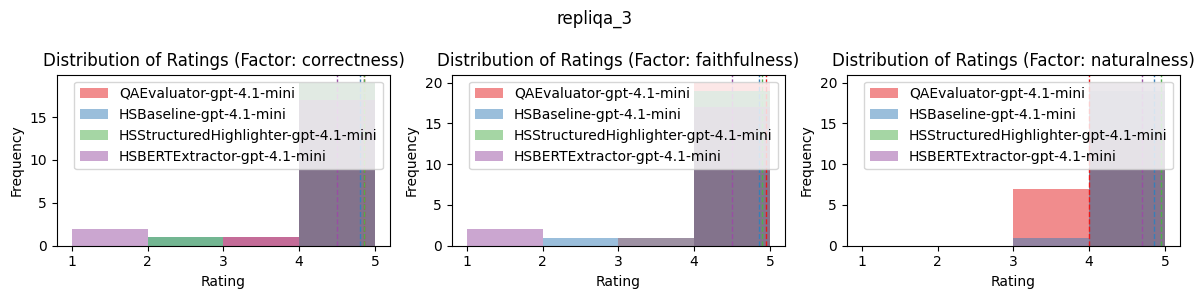

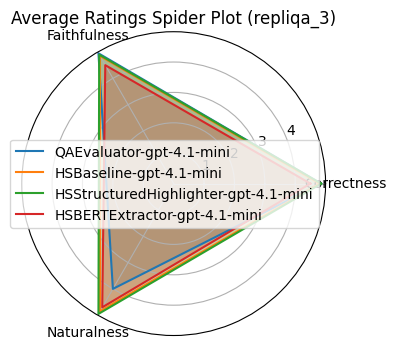

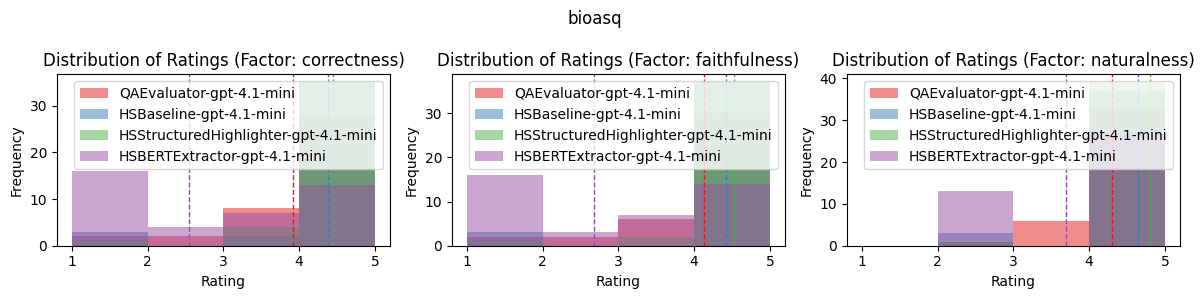

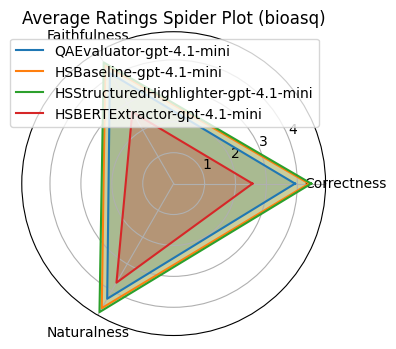

In [7]:
judge_name = "MT-bench-QA"
llms = ["gpt-4.1-mini"]
for dataset_name, dataset_ratings in ratings.items():
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 3))
    for factor, ax in zip(["correctness", "faithfulness", "naturalness"], axes.flatten()):
        #plt.figure(figsize=(4, 3))
        colors = sns.color_palette("Set1", n_colors=len(dataset_ratings))
        for model_name in dataset_ratings:
            model_ratings = dataset_ratings[model_name]
            color = colors.pop(0)
            judge_ratings = model_ratings[f"{judge_name}_{factor}"]
            ax.hist(judge_ratings, alpha=0.5, label=f"{model_name}", color=color, density=False, bins=np.arange(MIN_RATING, MAX_RATING + 1, 1))
            # A vertical line for each model's average rating.
            avg_rating = np.mean(judge_ratings)
            ax.axvline(avg_rating, linestyle='--', linewidth=1, color=color) #label=f"{model_name} Avg"

        ax.set_xlabel("Rating")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Distribution of Ratings (Factor: {factor})")
        # plt.suptitle(dataset_name)
        ax.set_xticks(np.arange(MIN_RATING, MAX_RATING + 1, 1))
        ax.legend()
        plt.suptitle(dataset_name)
        plt.tight_layout()
    
    # A spider plot for each model's average ratings.
    spider_data = {}
    for model_name in dataset_ratings:
        model_ratings = dataset_ratings[model_name]
        avg_ratings = [np.mean(model_ratings[f"{judge_name}_{factor}"]) for factor in ["correctness", "faithfulness", "naturalness"]]
        spider_data[model_name] = avg_ratings
    # Create a spider plot.
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
    num_vars = len(spider_data[next(iter(spider_data))])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    for model_name, avg_ratings in spider_data.items():
        avg_ratings += avg_ratings[:1]  # Complete the loop
        ax.plot(angles, avg_ratings, label=model_name)
        ax.fill(angles, avg_ratings, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(["Correctness", "Faithfulness", "Naturalness"])
    ax.set_title(f"Average Ratings Spider Plot ({dataset_name})")
    plt.legend()
    plt.tight_layout()

#### Unanswerable

Filter:   0%|          | 0/40 [00:00<?, ? examples/s]

Filter: 100%|██████████| 20/20 [00:00<00:00, 4199.34 examples/s]


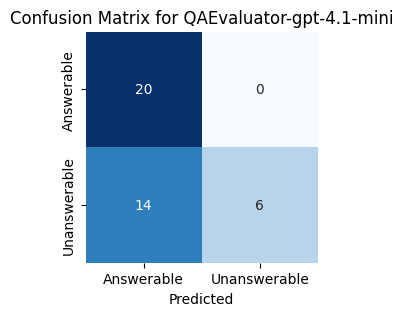

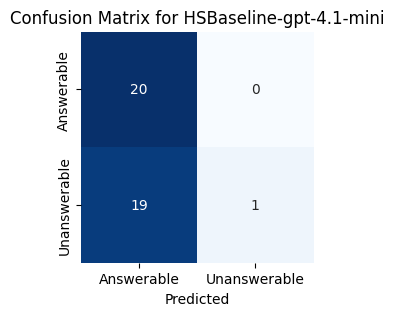

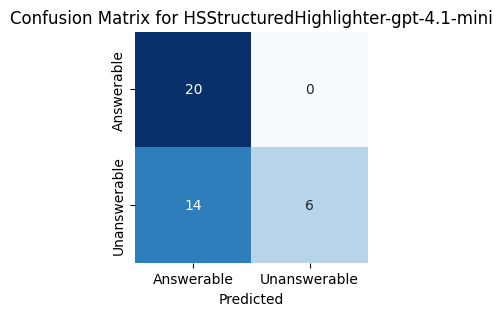

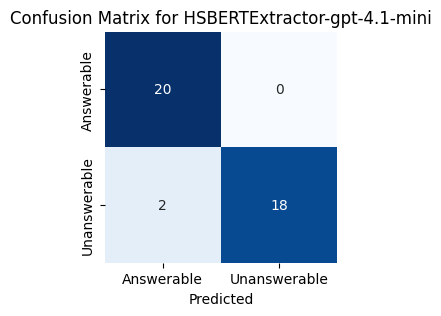

In [8]:
# Confusion matrix for (answer is answerable/unanswerable, answer_pred is answerable/unanswerable)
judged_dataset = inference_datasets["repliqa_3"]
for model_name in judged_dataset:
    answerable = judged_dataset[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    unanswerable = judged_dataset[model_name].filter(
        lambda example: example["answer"] == NOANSWER_PRED
    )
    answerable_correct = len(answerable.filter(lambda example: example["answer_pred"] != NOANSWER_PRED))
    unanswerable_correct = len(unanswerable.filter(lambda example: example["answer_pred"] == NOANSWER_PRED))

    # Plot as confusion matrix.
    confusion_matrix = np.array([[answerable_correct, len(answerable) - answerable_correct],
                                  [len(unanswerable) - unanswerable_correct, unanswerable_correct]])
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted") 

#### Recall and K-F1

Referring to https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00667/121196.

In [ ]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def ref_answer_recall(answer, answer_pred):
    """This metric measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    if answer == NOANSWER_PRED:
        raise ValueError("Reference answer is NOANSWER_PRED.")

    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    answer_tokens = set(enc.encode(answer))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = answer_tokens.intersection(answer_pred_tokens)
    recall = len(common_tokens) / len(answer_tokens)
    return recall

def ref_passage_precision(passage, answer_pred):
    """This metric measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.
    """
    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    passage_tokens = set(enc.encode(passage))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = passage_tokens.intersection(answer_pred_tokens)
    precision = len(common_tokens) / len(answer_pred_tokens)
    return precision

Model: QAEvaluator-gpt-4.1-mini
  Ref Answer Recall: 0.6697
  Ref Passage Precision: 0.8101
Model: HSBaseline-gpt-4.1-mini
  Ref Answer Recall: 0.7633
  Ref Passage Precision: 0.7268
Model: HSBaseline-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7327
  Ref Passage Precision: 0.8795
Model: HSStructuredHighlighter-gpt-4.1-mini
  Ref Answer Recall: 0.8202
  Ref Passage Precision: 0.7334
Model: HSStructuredHighlighter-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7909
  Ref Passage Precision: 0.8879
Model: HSBERTExtractor-gpt-4.1-mini
  Ref Answer Recall: 0.7236
  Ref Passage Precision: 0.6389
Model: HSBERTExtractor-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.4530
  Ref Passage Precision: 0.7829
Skipping dataset bioasq for evaluation because it doesn't contain `long_answer`.


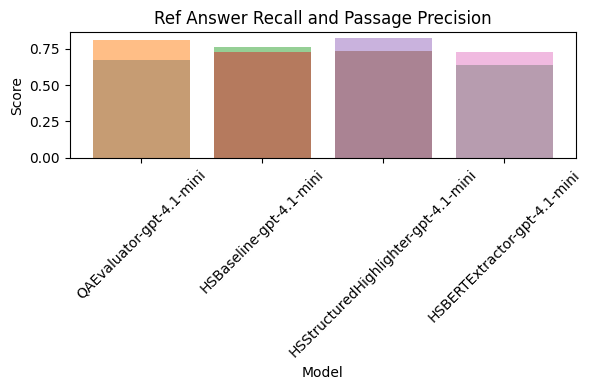

In [10]:
results = {}
for dataset_name, judged_predictions in inference_datasets.items():
    if dataset_name != "repliqa_3":
        print(f"Skipping dataset {dataset_name} for evaluation because it doesn't contain `long_answer`.")
        continue
    for model_name, dataset in judged_predictions.items():
        if not "mini" in model_name:
            continue
        results[model_name] = {
            "ref_answer_recall": [],
            "ref_passage_precision": [],
            "answer_length": [],
            "answer_pred_length": []
        }
        for example in dataset:
            # We skip unanswerable questions.
            if example["answer"] == NOANSWER_PRED:
                continue
            results[model_name]["ref_answer_recall"].append(
                ref_answer_recall(example["answer"], example["answer_pred"])
            )
            results[model_name]["ref_passage_precision"].append(
                ref_passage_precision(example["long_answer"], example["answer_pred"])
            )
        print(f"Model: {model_name}")
        print(f"  Ref Answer Recall: {np.mean(results[model_name]['ref_answer_recall']):.4f}")
        print(f"  Ref Passage Precision: {np.mean(results[model_name]['ref_passage_precision']):.4f}")

        # We also evaluate just the highlighter (i.e., no summarizer) for HS pipelines.
        if "HS" in model_name:
            results[f"{model_name}-highlighter"] = {
                "ref_answer_recall": [],
                "ref_passage_precision": [],
                "answer_length": [],
                "answer_pred_length": []
            }
            for example in dataset:
                if example["answer"] == NOANSWER_PRED:
                    continue
                results[f"{model_name}-highlighter"]["ref_answer_recall"].append(
                    ref_answer_recall(example["answer"], example["highlighter_extracted"])
                )
                results[f"{model_name}-highlighter"]["ref_passage_precision"].append(
                    ref_passage_precision(example["long_answer"], example["highlighter_extracted"])
                )
            print(f"Model: {model_name}-highlighter")
            print(f"  Ref Answer Recall: {np.mean(results[f'{model_name}-highlighter']['ref_answer_recall']):.4f}")
            print(f"  Ref Passage Precision: {np.mean(results[f'{model_name}-highlighter']['ref_passage_precision']):.4f}")

    # Plot the results as a bar chart.
    plt.figure(figsize=(6, 4))
    for model_name, result in results.items():
        if not "mini" in model_name:
            continue
        if "highlighter" in model_name:
            # Skip highlighter-only models for this plot.
            continue
        plt.bar(model_name, np.mean(result["ref_answer_recall"]), label=f"{model_name} Recall", alpha=0.5)
        plt.bar(model_name, np.mean(result["ref_passage_precision"]), label=f"{model_name} Precision", alpha=0.5)
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title("Ref Answer Recall and Passage Precision")
    plt.xticks(rotation=45)
    # plt.legend()
    plt.tight_layout()